In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# US Adidas sales

### 1. The Context
The U.S. market is a pivotal arena for global sports brands like Adidas. Analyzing sales data within this region offers crucial insights into consumer preferences and market dynamics. This study aims to dissect Adidas's sales across various U.S. regions, focusing on identifying areas of strength and opportunities for growth.

### 2. The Objective
The primary goal is to conduct a detailed analysis of Adidas's sales data in the U.S. This involves:
- **Exploratory Data Analysis (EDA)**: Understanding the patterns and anomalies in the sales data.
- **Geo-Spatial Analysis**: Utilizing geo-spatial tools to visualize and interpret sales across different geographic segments (regions, states, cities).

### 3. The Key Questions
- How do sales figures and patterns differ across various U.S. regions, states, and cities?
- What trends emerge from a geo-spatial analysis of the sales data?

### 4. The Problem Formulation
This project aims to uncover the underlying dynamics of Adidas's sales performance across the U.S., identifying high-performing areas and those needing improvement. The insights gained will guide strategic decisions and marketing efforts to bolster Adidas's presence in the U.S. market.

## Table of contents
- [Data cleaning](#Data-cleaning)
- [Data cleaning summary](#Data-cleaning-summary)
- [Analysis](#Analysis)
- [Analysis summary](#analysis-summary)
- [Insights and conclusion](#Insights-and-conclusion)

### Data Dictionary

| Column            | Data Type | Description                                                       |
|-------------------|-----------|-------------------------------------------------------------------|
| Retailer          | object    | The name of the retailer that sells Adidas products.              |
| Retailer ID       | int       | A unique ID for each retailer.                                    |
| Invoice Date      | object    | The date of the sales transaction.                                |
| Region            | object    | The geographic area where the sale occurs.                        |
| State             | object    | The state where the sale occurred.                                |
| City              | object    | The city where the sale occurred.                                 |
| Product           | object    | The category of the product being sold.                           |
| Price per Unit    | float     | The unit price of the product.                                    |
| Units Sold        | int       | The number of units of the product sold.                          |
| Total Sales       | float     | Total revenue from the product sale.                              |
| Operating Profit  | float     | The profit generated from the product sale.                       |
| Operating Margin  | float     | The percentage of profit generated from the sale of the product.  |
| Sales Method      | object    | The method of sale used by retailers (Online/In-store/Outlet).    |

In [36]:
# Data manipulation and formatting
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
np.set_printoptions(suppress=True)
# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
# Statistics
import scipy.stats as stats
import statsmodels.api as sm
np.set_printoptions(suppress=True)

In [101]:
data =  pd.read_csv("/Users/moiezismail/projects/adidas sales/adidas_csv_master.csv")

In [102]:
sales = data.copy()
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        0 non-null      float64
 1   Retailer          9648 non-null   object 
 2   Retailer ID       9648 non-null   int64  
 3   Invoice Date      9648 non-null   object 
 4   Region            9648 non-null   object 
 5   State             9648 non-null   object 
 6   City              9648 non-null   object 
 7   Product           9648 non-null   object 
 8   Price per Unit    9648 non-null   object 
 9   Units Sold        9648 non-null   object 
 10  Total Sales       9648 non-null   object 
 11  Operating Profit  9648 non-null   object 
 12  Operating Margin  9648 non-null   object 
 13  Sales Method      9648 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.0+ MB


In [103]:
sales.sample(3)

,Unnamed: 0,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
3074,NaN,West Gear,1185732,10/6/2021,Midwest,Iowa,Des Moines,Women's Apparel,$50.00,250,"$125,000","$50,000",40%,In-store
1273,NaN,Amazon,1185732,10/22/2021,West,Alaska,Anchorage,Men's Street Footwear,$70.00,450,"$315,000","$110,250",35%,Outlet
3895,NaN,Foot Locker,1185732,1/8/2020,Northeast,New York,New York,Men's Athletic Footwear,$46.00,261,"$12,006","$5,283",44%,Online


#### Initial observations: 
1. need to convert object d-types to numerical in order to get statistics and perform analysis
2. The data is one table but can split into two tables, one for order information, and one for store information for storage and quering in GCP. We'll used the cleaned sales table to perform analysis, visualizaiton, and predictive modeling. 
3. We can get a variety of different insights and visualizations because there is geographic, categorical, and numeric data.
4. The target variable in question is "Total sales" as that describes a store's overall performance, the task is to find what features of the store are most important in predicting that value.

## Data cleaning

In [104]:
#Drop the unnamed column
sales.drop(columns=["Unnamed: 0"], inplace=True)

# Columns to convert from currency format to float
currency_cols = ['Total Sales', 'Operating Profit', 'Price per Unit']

# Remove dollar signs and commas, then convert to float
for col in currency_cols:
    sales[col] = sales[col].str.replace(
        '$', '',regex=False).str.replace(
        ',','', regex=False).astype(float)

# Remove percentage signs from 'Operating Margin', then convert to int
sales["Operating Margin"] = sales["Operating Margin"].str.replace('%', '', regex=False).astype(int)
# Remove commas from 'Units Sold' and convert to int`
sales['Units Sold'] = sales['Units Sold'].str.replace(',', '', regex=False).astype(int)
# Convert 'Invoice Date' to datetime format of yyyy-mm-dd
sales["Invoice Date"] = pd.to_datetime(sales['Invoice Date'])
#Rename columns
sales= sales.rename(columns={
    'Operating Profit':'Oper_prof',
    'Price per Unit':'Price',
    'Product':'Prod_cat',
    'Invoice Date':'Invoice_date',
    'Units Sold':'units_sold', 
    'Total Sales':'Sales',
    'Retailer ID':'Retailer_ID',
    'Operating Margin':'sales_marg',
    'Sales Method':'Method'})

In [105]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Prod_cat,Price,units_sold,Sales,Oper_prof,sales_marg,Method
4436,West Gear,1128299,2020-02-19,West,Nevada,Las Vegas,Men's Street Footwear,56.00,174,9744.00,4677.00,48,Online
3891,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,41.00,247,10127.00,4658.00,46,Online
6445,Amazon,1185732,2021-08-22,Southeast,Kentucky,Louisville,Men's Apparel,49.00,65,3185.00,1561.00,49,Online


#### Change float dtype to integer

In [106]:
sales[['Sales','Price', 'Oper_prof']] = sales[[
    'Sales','Price', 'Oper_prof']].astype(int)

In [107]:
# Check if the total sales are indeed units sold x price per unit in the 'sales' DataFrame
sales['Sales_match'] = sales[
    'Sales'] == sales['units_sold'] * sales[
    'Price']
sales['Sales_match'].value_counts()

True     5762
False    3886
Name: Sales_match, dtype: int64

#### Observation: 
- Total sales is NOT a direct result of total units sold multiplied by price per unit

#### Unique retailer_id and invoice_id

In [108]:
import random

# Generate unique 4-digit IDs for each retailer
unique_retailers = sales['Retailer'].unique()
retailer_id_dict = {retailer: random.randint(1000, 9999) for retailer in unique_retailers}
sales['Retailer_ID'] = sales['Retailer'].map(retailer_id_dict)

# Generate a random number
random_number = [random.randint(10000000, 99999999) for _ in range(len(sales))]

# Assign the random numbers to 'Invoice ID'
sales['Invoice_ID'] = random_number

sales[['Retailer_ID','Invoice_ID']] = sales[['Retailer_ID','Invoice_ID']].astype(str)

In [109]:
#### Check if there are any duplicate IDs
sales[sales['Invoice_ID'].duplicated()]

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Prod_cat,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID


In [110]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Prod_cat,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID
1871,West Gear,3665,2021-02-24,West,Utah,Salt Lake City,Women's Street Footwear,40,350,140000,49000,35,In-store,False,20632229
6574,Walmart,3789,2021-06-21,South,Arkansas,Little Rock,Men's Athletic Footwear,32,106,3392,1662,49,Online,True,12563451
7635,Amazon,8304,2021-03-10,Northeast,Vermont,Burlington,Men's Street Footwear,44,142,6248,3749,60,Online,True,91375691


In [111]:
sales.drop(columns=['Retailer_ID']).describe().T

,count,mean,std,min,25%,50%,75%,max
Price,9648.00,45.22,14.71,7.00,35.00,45.00,55.00,110.00
units_sold,9648.00,256.93,214.25,0.00,106.00,176.00,350.00,1275.00
Sales,9648.00,93273.44,141916.02,0.00,4254.50,9576.00,150000.00,825000.00
Oper_prof,9648.00,34425.28,54193.12,0.00,1922.00,4371.50,52063.00,390000.00
sales_marg,9648.00,42.30,9.72,10.00,35.00,41.00,49.00,80.00


### Observations

There are values as 0 for units sold, total sales, operating profit which is consistent but strange that no products are sold at all. 

- **Price per Unit**: The majority of units are priced between `$35` and `$55`, with outliers reaching 2x to `$110`. This suggests a range of products from budget to premium.

- **Units Sold**: On average, approximately `257` units are sold per transaction. The standard deviation of `214.25` indicates significant variation in sales volumes.

- **Total Sales**: The sales figures show a wide disparity, ranging from `$0` to `$825,000`. The upper quartile starts at `$150,000`, indicating a few exceptionally high sales transactions.

- **Operating Profit**: The profit also varies widely, with a mean of `$34,425.28` and a maximum of `$390,000`. The standard deviation of `54193.12` suggests a high variability in profitability.

- **Operating Margin**: The data points are mostly clustered around the mean value of `42.3%`, with a relatively small standard deviation of `9.72`, indicating a generally consistent operating margin across transactions.

In [112]:
sales[sales['units_sold'] == 0]

# something strange is going on in Omaha as on june 5th and june 11th there were no sales
# would need to ask the sales team or call the store to ask them about that. 

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Prod_cat,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID
1019,Foot Locker,1201,2021-06-05,Midwest,Nebraska,Omaha,Women's Athletic Footwear,35,0,0,0,40,Outlet,True,29386831
1025,Foot Locker,1201,2021-06-11,Midwest,Nebraska,Omaha,Women's Athletic Footwear,30,0,0,0,40,Outlet,True,23022880
4907,Foot Locker,1201,2021-06-05,Midwest,Nebraska,Omaha,Women's Athletic Footwear,33,0,0,0,55,Online,True,84285755
4913,Foot Locker,1201,2021-06-11,Midwest,Nebraska,Omaha,Women's Athletic Footwear,27,0,0,0,53,Online,True,78820831


#### Drop rows with 0 units sold

In [113]:
sales.drop(sales[sales['units_sold'] == 0].index,inplace=True)

#### Flag weekend days

In [114]:
# Extract the day of the week from 'Invoice Date' (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
sales['Day'] = sales['Invoice_date'].dt.dayofweek
#Now we'll assign the numbered days with resepctive categorical variables such as names
day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
sales['Day'] = sales['Day'].map(day_map)

# Assign 'D' for weekday and 'W' for weekend
sales['D/W'] = sales['Day'].apply(lambda x: 'W' if x in ['Sat','Sun'] else 'D')

In [115]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Prod_cat,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID,Day,D/W
1922,West Gear,3665,2021-10-24,West,Oregon,Portland,Women's Apparel,60,350,210000,63000,30,In-store,False,16220143,Sun,W
5968,Foot Locker,1201,2021-01-23,West,Idaho,Boise,Men's Athletic Footwear,37,106,3922,2000,51,Online,True,27725572,Sat,W
1908,West Gear,3665,2021-08-24,West,Oregon,Portland,Women's Athletic Footwear,70,425,297500,104125,35,In-store,False,56646037,Tue,D


#### Check data of total sales

In [119]:
(sales['Sales'] == sales['units_sold'] * sales['Price']).value_counts()

True     5758
False    3886
dtype: int64

#### Observation:
- This is a problem as I expected the total sales to simply a result of calculating unit price multiplied by the number of units sold. It is true for some but not for quite a large number. This will skew the analysis quite a bit 
- Will drop the rows which are false

In [120]:
sales = sales[sales['Sales'] == sales['units_sold'] * sales['Price']]

#### Create cost of goods column
-Constraints of the Dataset: 
- **Lack of Detailed Cost Breakdown**: The dataset does not include direct information on the Cost of Goods Sold (COGS) or a breakdown of operating expenses. This absence of granular cost data limits our ability to precisely calculate COGS.

In [121]:
sales['cost'] = (sales['Sales'] - sales['Oper_prof']) / sales['units_sold']

In [122]:
sales.sample(3)

,Invoice_date,Prod_cat,Price,units_sold,Sales,Day,D/W,Oper_prof,sales_marg,Retailer,Region,State,City,Method,Invoice_ID,Retailer_ID,cost_per_unit
9372,2021-04-07,Women's Athletic Footwear,21,17,357,Wed,D,161,45,Foot Locker,Northeast,Rhode Island,Providence,Outlet,34261475,1201,11.53
8734,2021-06-17,Men's Athletic Footwear,55,224,12320,Thu,D,5544,45,West Gear,South,Louisiana,New Orleans,Outlet,41896107,3665,30.25
4295,2021-10-01,Women's Athletic Footwear,56,126,7056,Fri,D,4586,65,Sports Direct,South,Texas,Dallas,Online,29967039,6032,19.60


#### Rearrange the columns

In [ ]:
stores = sales[['Retailer', 'Region', 'State', 'City', 'Oper_prof', 'sales_marg', 
                'Retailer_ID']]

orders = sales[['Invoice_date', 'Prod_cat', 'Price', 'units_sold', 'Sales',
                'cost_per_unit', 'Oper_prof', 'sales_marg', 'Method', 'Invoice_ID',
                'Retailer_ID']]

sales = sales[['Invoice_date', 'Retailer', 'Prod_cat', 'Price', 'cost_per_unit', 
               'units_sold', 'Sales', 'Day', 'D/W', 'Oper_prof', 'sales_marg',
               'Region', 'State', 'City', 'Method', 'Invoice_ID', 'Retailer_ID']]

### Data Cleaning Summary
1. **Drop Unnamed Column**: Removed the "Unnamed: 0" column as it contained no useful information.
2. **Currency Conversion**: Converted 'Total Sales', 'Operating Profit', and 'Price per Unit' from strings to floats, removing dollar signs and commas.
3. **Percentage Conversion**: Removed percentage signs from 'Operating Margin' and converted it to an integer data type.
4. **Units Sold Conversion**: Removed commas from 'Units Sold' and converted it to an integer data type.
5. **Date Formatting**: Converted 'Invoice Date' to datetime format (yyyy-mm-dd).
6. **Data Type Conversion**: Converted 'Total Sales', 'Price per Unit', and 'Operating Profit' to integer data types.
7. **Unique IDs Generation**: Generated unique IDs for 'Retailer' and 'Invoice', converting both to string data types.
8. **Check Sales Calculation**: Validated that 'Total Sales' equals 'Units Sold' multiplied by 'Price per Unit'. Dropped rows where this calculation did not hold true.
9. **Create Cost of Goods Column**: Estimated the cost per unit for each product as `(Sales - Oper_prof) / units_sold`.
10. **Data Rearrangement**: Rearranged columns for better readability and data analysis. 

#### Data Split for Analysis
- **Stores Table**: Created with selected store-related information (`Retailer`, `Region`, `State`, `City`, `Oper_prof`, `sales_marg`, `Retailer_ID`).
- **Orders Table**: Created with detailed transaction information (`Invoice_date`, `Prod_cat`, `Price`, `units_sold`, `Sales`, `cost_per_unit`, `Oper_prof`, `sales_marg`, `Method`, `Invoice_ID`, `Retailer_ID`).

#### Observations and Insights
- Identified anomalies like zero values in 'Units Sold', indicating instances with no product sales.
- Noted the disparity between calculated and reported 'Total Sales', necessitating the removal of inconsistent rows.
- Acknowledged the limitations in estimating the cost of goods sold due to the lack of detailed breakdowns.

#### Next Steps
- Continue with data analysis, visualization, and predictive modeling using the cleaned and structured dataset.
- Further investigate any anomalies or inconsistencies for a deeper understanding of the sales data.

In [96]:
adidas = sales.copy()
adidas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5758 entries, 3888 to 9647
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Invoice_date  5758 non-null   datetime64[ns]
 1   Prod_cat      5758 non-null   object        
 2   Price         5758 non-null   int64         
 3   units_sold    5758 non-null   int64         
 4   Sales         5758 non-null   int64         
 5   Day           5758 non-null   object        
 6   D/W           5758 non-null   object        
 7   Oper_prof     5758 non-null   int64         
 8   sales_marg    5758 non-null   int64         
 9   Retailer      5758 non-null   object        
 10  Region        5758 non-null   object        
 11  State         5758 non-null   object        
 12  City          5758 non-null   object        
 13  Method        5758 non-null   object        
 14  Invoice_ID    5758 non-null   object        
 15  Retailer_ID   5758 non-null   objec

#### Export as cleaned CSV file for Tableau 

stores.to_csv('stores.csv', index=False)
orders.to_csv('orders.csv',index=False)

In [123]:
adidas.to_csv('final_adidas.csv', index=False)

## Analysis
- understand data distributions, patterns, and anomalies. Use mapping tools to visualize sales distribution across different geographical levels
- Location-based Segmentation Analysis: Calculate key performance indicators (KPIs) like average sales, total sales, and sales growth for each geographical unit (region, state, city).

In [125]:
adidas.sample(3)

,Invoice_date,Prod_cat,Price,units_sold,Sales,Day,D/W,Oper_prof,sales_marg,Retailer,Region,State,City,Method,Invoice_ID,Retailer_ID
7016,2021-07-02,Women's Apparel,52,94,4888,Fri,D,2640,54,West Gear,Midwest,Wisconsin,Milwaukee,Online,84413412,1807
8505,2021-04-24,Men's Street Footwear,38,147,5586,Sat,W,2067,37,Foot Locker,Southeast,Virginia,Richmond,Outlet,39684251,8948
5177,2021-01-10,Women's Street Footwear,41,113,4633,Sun,W,1668,36,Foot Locker,West,Alaska,Anchorage,Online,67249039,8948


In [126]:
adidas.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,5758.00,42.87,14.01,7.00,33.00,42.00,52.00,103.00
units_sold,5758.00,133.16,68.33,6.00,80.00,124.00,176.00,434.00
Sales,5758.00,5823.09,3771.89,160.00,2915.25,4998.00,7902.75,23220.00
Oper_prof,5758.00,2703.80,1886.74,75.00,1290.25,2253.00,3604.00,12574.00
sales_marg,5758.00,46.34,8.78,12.00,41.00,46.00,52.00,80.00


#### Observations
- **Price (Price per Unit)**: Average around \$45.22, ranging from \$7 to \$110 with moderate variation.
- **Units Sold**: Average 257 units, with a wide range from 6 to 1275 units, indicating varied product popularity.
- **Total Sales**: Average sales per transaction are approximately \$93,312.12, but highly variable, ranging from \$160 to \$825,000.
- **Operating Profit (Oper_prof)**: Average operating profit is about \$34,439.56, with a large range from \$75 to \$390,000, suggesting varied profitability.
- **Sales Margin (sales_marg)**: Average margin at 42.3%, but varies widely from 10% to 80%, indicating differences in profitability across products.

#### Let's see the spread of some variables

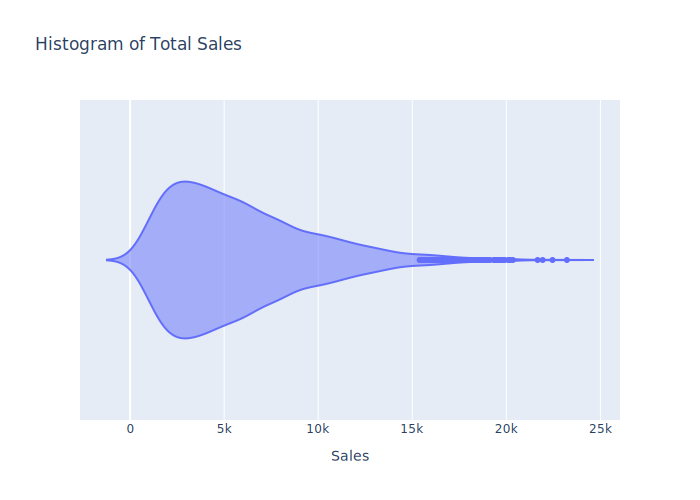

In [127]:
px.violin(adidas, x='Sales', title='Histogram of Total Sales')

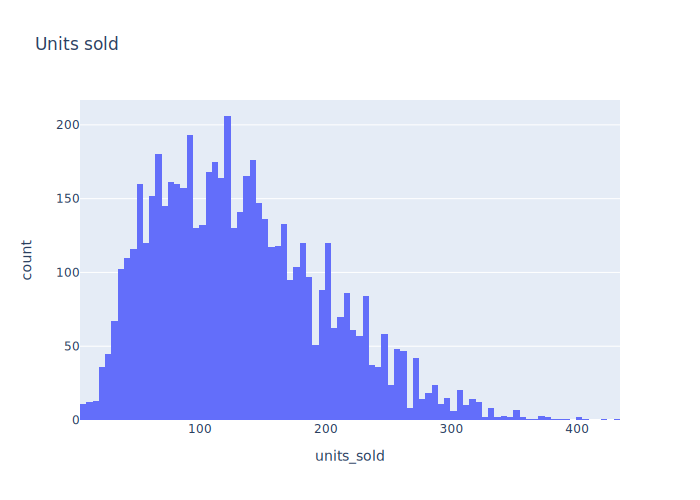

In [128]:
px.histogram(adidas, x='units_sold', title='Units sold')

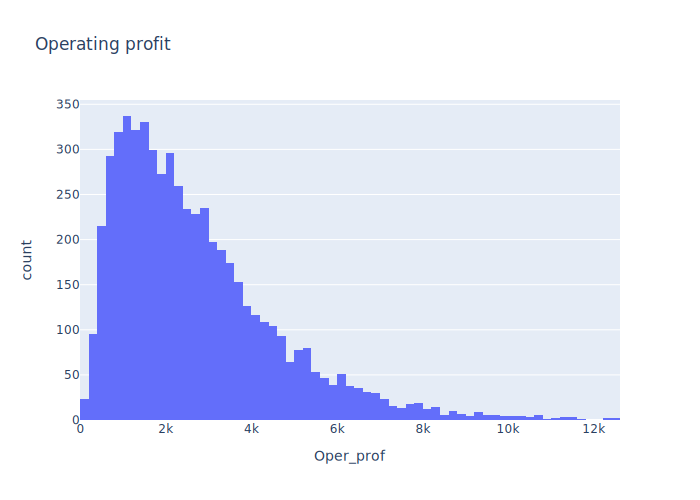

In [129]:
px.histogram(adidas, x='Oper_prof', title='Operating profit')

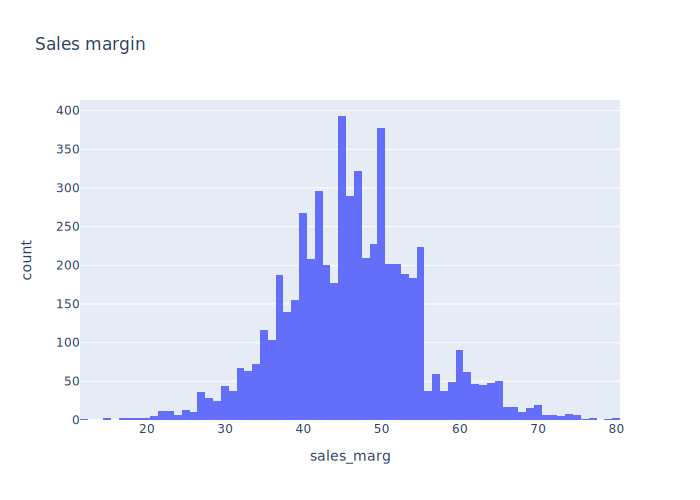

In [130]:
px.histogram(adidas, x='sales_marg', title='Sales margin')

#### Total sales analysis across regions and product

In [137]:
# Performing the aggregations in a single step
aggregated_data = adidas.groupby(['Region', 'Prod_cat']).agg({
    'Oper_prof': 'mean',  # Average Operating Profit
    'sales_marg': 'mean',  # Average Operating Margin
    'Sales': 'sum'         # Total Sales Sum
}).reset_index()

# Renaming the columns for clarity
aggregated_data.columns = ['Region', 'Prod_cat', 'Avg_Operating_Profit', 
                           'Avg_Operating_Margin', 'SUM_Sales']

aggregated_data

,Region,Prod_cat,Avg_Operating_Profit,Avg_Operating_Margin,SUM_Sales
0,Midwest,Men's Apparel,1525.83,51.33,456911
1,Midwest,Men's Athletic Footwear,1633.86,46.74,543039
2,Midwest,Men's Street Footwear,3197.17,50.46,972310
3,Midwest,Women's Apparel,2516.13,55.53,702633
4,Midwest,Women's Athletic Footwear,1116.92,48.16,348918
5,Midwest,Women's Street Footwear,1269.63,46.38,414398
6,Northeast,Men's Apparel,1702.03,40.50,1000662
7,Northeast,Men's Athletic Footwear,2081.73,45.46,1120487
8,Northeast,Men's Street Footwear,4143.72,50.02,1932024
9,Northeast,Women's Apparel,2625.41,45.07,1434333


#### Total sales across regions visualized

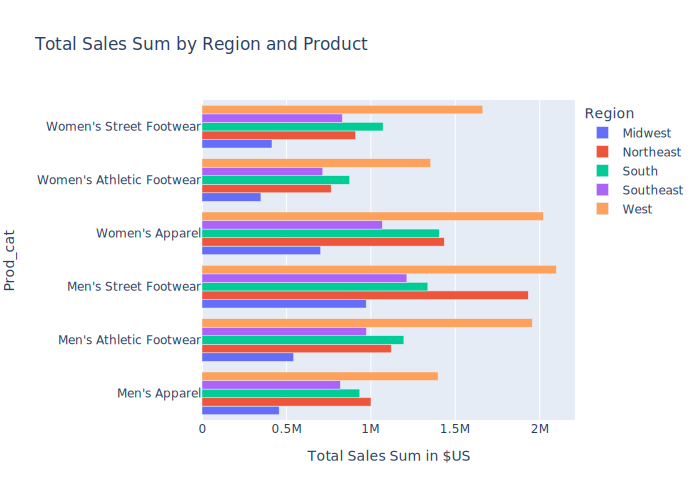

In [138]:
fig = px.bar(aggregated_data, 
             x='SUM_Sales', 
             y='Prod_cat', 
             color='Region', 
             barmode='group',
             title='Total Sales Sum by Region and Product',
             labels={'Total Sales Sum': 'Total Sales Sum', 'Prod_cat': 'Product category'},
             orientation='h')
fig.update_layout(
    xaxis_title='Total Sales Sum in $US',
    yaxis_title='Prod_cat',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Total Sales Sum by Region and Product
- Men's Street Footwear and Women's Apparel show the highest sales sums across almost all regions, suggesting they are popular or well-marketed products.
- The West region shows the highest sales sums for nearly all product categories, indicating a larger market size or more effective sales strategies in that region.

#### Average Operating profit across region

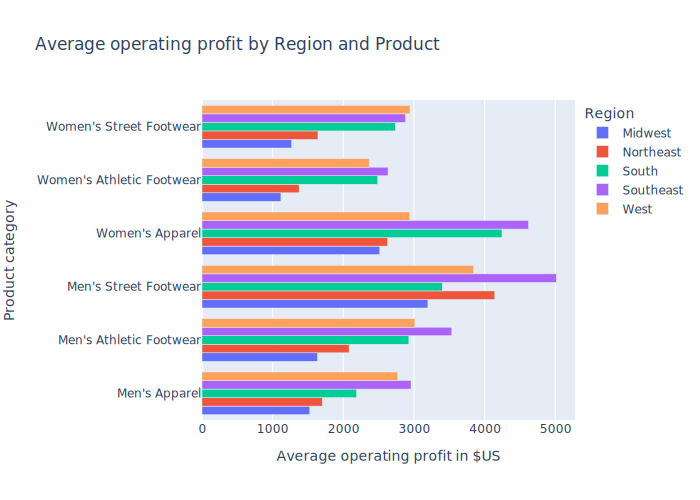

In [139]:
fig = px.bar(aggregated_data, 
             x='Avg_Operating_Profit', 
             y='Prod_cat', 
             color='Region', 
             barmode='group',
             title='Average operating profit by Region and Product',
             orientation='h')
fig.update_layout(
    xaxis_title='Average operating profit in $US',
    yaxis_title='Product category',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Average Operating Profit by Region and Product
- Men's Street Footwear has notably higher average operating profits in some regions, indicating this category could be a significant contributor to absolute profit.
- The West region seems to consistently have higher operating profits across most product categories, possibly indicating higher sales volumes or better cost management.

#### Average operating margin across regions

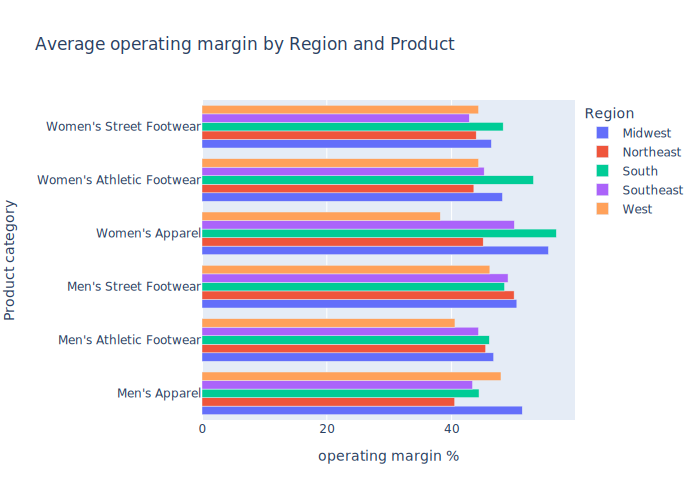

In [140]:
fig = px.bar(aggregated_data, 
             x='Avg_Operating_Margin', 
             y='Prod_cat', 
             color='Region', 
             barmode='group',
             title='Average operating margin by Region and Product',
             orientation='h')
fig.update_layout(
    xaxis_title='operating margin %',
    yaxis_title='Product category',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Average Operating Margin by Region and Product
- The operating margins are relatively consistent across regions for the same product categories.
- Women's Street Footwear and Women's Athletic Footwear appear to have higher operating margins compared to other categories, suggesting they might be more profitable relative to their sales.

### Comparing regions by sales method frequency

#### Hypothesis Test for Sales Across Regions
- Question : Are there are significant differences in the average sales across different regions? 
- Method: ANOVA (Analysis of Variance) test. The ANOVA test will assess whether the observed differences in sales averages across regions are statistically significant, or if they could have arisen by chance.
#### Null Hypothesis (H_0)
The null hypothesis states that there is no significant variance in the sales averages across the different regions. 
#### Alternative Hypothesis (H_1)
- The alternative hypothesis suggests that at least one region has a significantly different average total sales compared to the others. 

#### alpha = 0.05

In [141]:
# aggregate total sales based on regions to prepare for the anova tests
northeast = adidas[adidas['Region'] == 'Northeast']['Sales']
south = adidas[adidas['Region'] == 'South']['Sales']
west = adidas[adidas['Region'] == 'West']['Sales']
midwest = adidas[adidas['Region'] == 'Midwest']['Sales']
southeast = adidas[adidas['Region'] == 'Southeast']['Sales']
alpha = 0.05
# Conduct the ANOVA test 
f_statistic, p_value = stats.f_oneway(northeast, south, west, midwest, southeast)
print(f"The f-stat:{round(f_statistic)} and p_value:{p_value}")
if p_value >= alpha:
    print("Failed to reject the null")
else:
    print("Sufficient evidence to reject the null")

The f-stat:201 and p_value:1.3951871877826812e-161
Sufficient evidence to reject the null


#### Observation: 
- Accoding to the ANOVA test, we can state that there is a significant difference between
averages of total sales across the regions. 

In [142]:
cont_table = pd.crosstab(adidas['Region'], adidas['Method'])
p = stats.chi2_contingency(cont_table)[1]
if p >= alpha:
    print("Failed to reject the null")
else:
    print("Sufficient evidence to reject the null")

Sufficient evidence to reject the null


In [143]:
p

8.606470720363596e-137

#### Visualize the contingency table

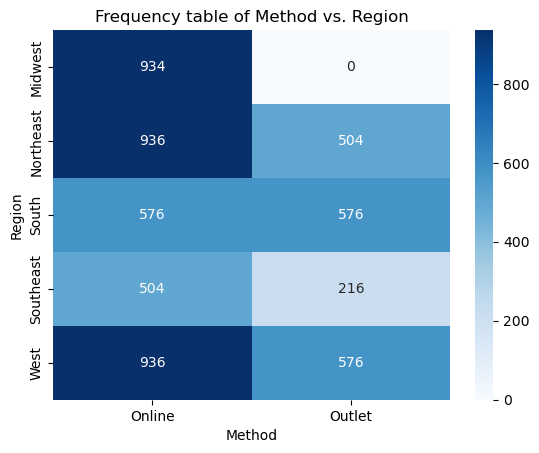

In [144]:
ax = sns.heatmap(cont_table, annot=True, cmap='Blues', fmt='g')
ax.set_title('Frequency table of Method vs. Region')
plt.show()

#### Observations
**Method Preference by Region:**
   - **Midwest:** Dominant preference for Online sales (1165), with low Outlet (262) sales.
   - **Northeast:** More balanced, but still favoring Online (936)
   - **South:** Balanced between  Outlet (864) and Online (844), with the lowest preference for In-store across the U.S. at (20).
   - **Southeast:** Strong preference for Online (792).
   - **West:** Similar to Midwest, high Online (1152) vs. In-store (398).

**Business Implications:** 
   - **Inventory and Marketing:** Align inventory to cater to region-specific sales preferences.
   - **Retail Store Optimization:** Consider store-specific sales/inventory to balance sales quantities based on each region
   - **Online and Outlet Expansion:** Invest in enhancing the online platform and outlet presence in regions showing higher preference for these channels.

## Insights and conclusion

### Insights:

**Product Category Performance**:
- Women's footwear, both street and athletic, tends to have higher operating margins, suggesting efficiency in generating profit relative to sales. This could be due to favorable pricing, lower production costs, or both.
- Men's Street Footwear emerges as a significant contributor to absolute profit in some regions, potentially due to higher price points or effective cost control measures.

**Regional Performance**:
- The West region exhibits consistently higher operating profits across most product categories, potentially indicating higher sales volumes, a larger customer base, or more effective marketing strategies.
- The strong sales of Men's Street Footwear and Women's Apparel across different regions indicate a robust market presence and consumer appeal.

### Conclusions:

- **Marketing**: Focusing marketing efforts on high-margin products like Men's Street Footwear and Women's Footwear could maximize profit margins and sales.
  
- **Regional focus**: The West region's strong performance deserves their continued investment while other regions require analysis to identify and address challenges.

- **Product Development**: High margins in Women's Footwear categories suggest that innovation and development in these lines could be beneficial.

- **Pricing and sales**: Variations in operating margins and profits across categories indicate opportunities for discounts and sales to improve total sales by increasing units sold.

- **Cost Management**: 

The analysis indicates strengths in various regions and product categories, particularly in the West and in categories like Men's Street Footwear and Women's Footwear. Understanding the drivers of success in these areas can guide strategies to enhance performance across the board.